In [1]:
import lib.Experiment as ex
from datasets.VOC_dataset import VOC_dataset
import torch.nn as nn
import numpy as np
from sklearn.metrics import average_precision_score
from torch.autograd.variable import Variable
import torch.utils.data
import torchvision.transforms as transforms
import networks.VGG16_224 as vgg_model
ex_dir='./data/training_luo_v1'
ex.check_dir(ex_dir)
voc_val=VOC_dataset(train='val', transform=transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()]),
                    label_transform=None  )#验证集
model=vgg_model.get_VGG16_224_model() #模型
print '下面要载入已经训练好的参数来进行测试了'

下面要载入已经训练好的参数来进行测试了


In [2]:
model.load_v2(checkpointFold=ex_dir,epoch=9)

=> loading checkpoint './data/training_luo_v1/checkpoint_9.tar'
=> loaded checkpoint train_stat '0.986083030283', val_stat '0.737800685691', (epoch 9)


In [3]:
print '下面开始考虑先处理单张图片的cam'
import lib.grad_cam.grad_main as grad_main
from lib.grad_cam.grad_cam import (BackPropagation, Deconvolution, GradCAM,
                      GuidedBackPropagation)
import cv2

print 'input img size: {}'.format((224,)*2)

下面开始考虑先处理单张图片的cam
input img size: (224, 224)


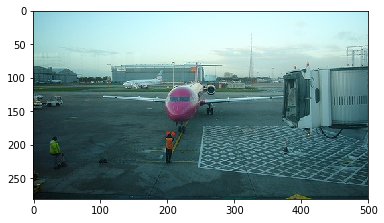

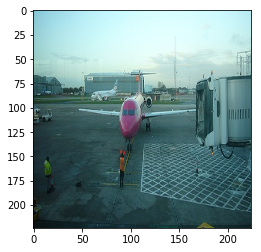

In [55]:
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
img_path='/home/kimy/data_sets/VOCdevkit/2012/VOC2012/JPEGImages/2007_000032.jpg'
raw_image = cv2.imread(img_path)[..., ::-1]
plt.figure("ori im")
plt.imshow(raw_image)
raw_image = cv2.resize(raw_image, (224, ) * 2)
plt.figure("resize im")
plt.imshow(raw_image)
image = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])
                           ])(raw_image)

In [56]:
model.cuda()
image = image.cuda()

#使用cuda
from lib.grad_cam.grad_cam import (BackPropagation, Deconvolution, GradCAM,
                      GuidedBackPropagation)
gcam=GradCAM(model=model)

In [57]:
print '测试图片'
probs, idx = gcam.forward(grad_main.to_var(image))
print 'prob:{} \n idx {} \n scores:{}'.format(probs,idx,gcam.preds)

测试图片
prob:
 9.9998e-01
 1.5470e-05
 1.0812e-11
 8.1348e-12
 3.9754e-12
 2.5066e-12
 1.1033e-12
 9.7912e-13
 6.4015e-13
 1.9952e-13
 4.9222e-14
 3.2028e-14
 9.6507e-15
 1.4256e-15
 4.9376e-16
 1.8639e-16
 1.5482e-16
 1.1434e-16
 8.2746e-17
 5.7157e-17
[torch.cuda.FloatTensor of size 20 (GPU 0)]
 
 idx 
  0
 14
  8
  2
  6
  4
 12
 19
 10
  1
 13
  3
  5
 18
 16
 11
  7
 17
 15
  9
[torch.cuda.LongTensor of size 20 (GPU 0)]
 
 scores:Variable containing:

Columns 0 to 7 
 13.4678 -15.7750 -12.0670 -17.6043 -13.2443 -18.8039 -12.7831 -22.9364

Columns 8 to 15 
-11.7826 -23.9329 -14.6092 -22.7508 -14.0649 -17.1746   2.3912 -23.5629

Columns 16 to 19 
-21.7766 -23.2395 -20.7163 -14.1843
[torch.cuda.FloatTensor of size 1x20 (GPU 0)]



In [58]:
gcam.backward(idx=idx[0])
for layer_name in model.named_modules():
    print layer_name

('', VGG_16_224(
  (embedding): vgg16_re(
    (conv_block1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
    )
    (conv_block2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
    )
    (conv_block3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

(14, 14)


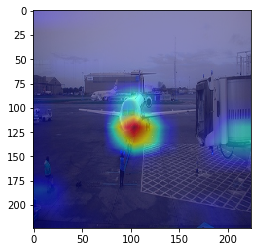

In [59]:
output = gcam.generate(target_layer='embedding.conv_block5.5')
print output.shape
sample_save_path=ex_dir+'/test_sample_v1.png'
grad_main.save_gradcam(sample_save_path,output,raw_image)
result = cv2.imread(sample_save_path)[..., ::-1]
plt.figure("result show")
plt.imshow(result)